In [1]:
%%capture
# DO NOT EDIT THIS NOTEBOOK
# It generates a report to verify your submission
import logging, sys, os
logging.disable(sys.maxsize)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import solution
import time
start_verify = time.time()
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,3)

In [2]:
%matplotlib inline
import os
import pickle
import pandas as pd
import numpy as np
import pydot
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import inspect
from IPython.core import page
page.page = print

grades = []

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')
        
def printSource(obj):
    print(''.join(str(x) for x in inspect.getsourcelines(obj)[0]))
        
# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

def print_answer(ans):
    output = ""
    for line in ans.splitlines()[1:]:
        output += line.strip() + " "
    output += "(length: "+str(len(output))+")\n"
    print(output)
        
def run_evaluation(name, model_builder, data, base_dir, target_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, print_model=True, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        grades.append("0")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Model not trained? Skipping.", verbose)
    else: # Load from file
        model = solution.load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
    # Report
    lc = pd.DataFrame(learning_curves)
    print("Max val score: {:.2f}%".format(lc.iloc[:,3].max()*100))
    grades.append("{:.2f}".format(lc.iloc[:,3].max()*100))
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    plt.show()
    
    if print_model:
        print(model.summary())
    plot_model(model, to_file=os.path.join(target_dir,name+'.png'), show_shapes=True, show_layer_names=False)
        
import pprint
pp = pprint.PrettyPrinter(indent=4)

### Web Information Retrieval and Data Mining - Assignment 3

In [3]:
grades.append(solution.target_dir.split(os.sep)[-1])
grades.append(solution.your_name)
print("Student: {0} ({1})".format(solution.your_name,solution.student_id))

Student: Hoogeveen, Dim (1518496)


#### Answer 1.1, Baseline (4p)
- Dense network, at least 3 layers, shaped like a pyramid
    - Last layer: 10 nodes, sigmoid. 
    - Loss: categorical cross-entropy. Metric: accuracy
- No preprocessing, regularization. Get at least 70% accuracy.
- Explain design decisions. Discuss performance.
    - Does it overfit (large/growing gap between loss and val_loss)?

Used a self-defined mathermetical formula to clearly define pyramid shape. Started with small (underfitting) then made bigger/more complex. Choice made to get overfitting model to later regularize. Different activations tried, but no significant differnce, therefore ReLu to compute faster. In the end high accuracies with 8 layers and many trainable parameters (10 million+), but trains quick enough.  (length: 403)



Max val score: 84.43%


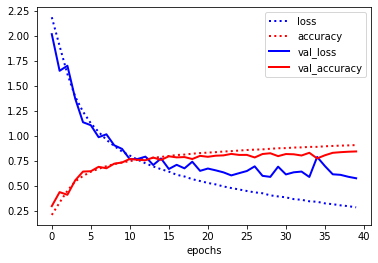

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 3072)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2318)              7123214   
_________________________________________________________________
dense_5 (Dense)              (None, 1174)              2722506   
_________________________________________________________________
dense_6 (Dense)              (None, 595)               699125    
_________________________________________________________________
dense_7 (Dense)              (None, 301)               179396    
_________________________________________________________________
dense_8 (Dense)              (None, 153)               46206     
_________________________________________________________________
dense_9 (Dense)              (None, 78)               

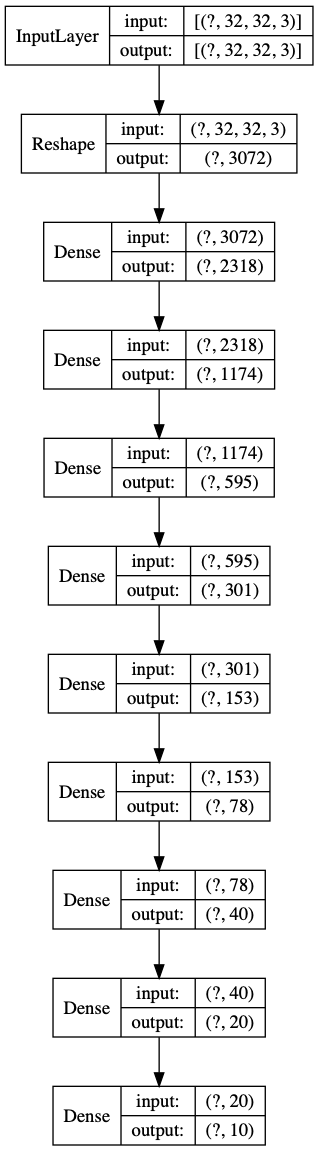

In [4]:
print_answer(solution.answer_q_1_1)
run_evaluation("model_1_1", solution.build_model_1_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_1
if os.path.exists(os.path.join(solution.target_dir,'model_1_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_1_1.png'), width=200))

#### Answer 1.2, Preprocess (2p)
- Convert images to greyscale, other preprocessing optional.
    - Input shape should be (32,32,1)
- Explain design decisions. Is it better? Why (not)? 
    - Color information is likely not so useful for classification. Greyscale makes the network smaller, less parameters to learn, less likely to overfit.

Near-equal accuracy after preprocessing (only rgb2gray). The training and validation losses represent accuracies different than in 1.1; for max validation accuracies there is 0.16 difference in loss, while the accuracy is roughly equal. Furthermore the trainable params. went down from 10 to 6 million. Model is faster to train therefore, which is a benefit over 1.1.   (length: 370)



Max val score: 84.42%


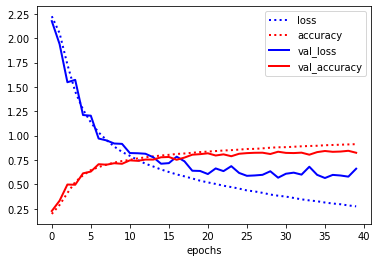

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 2318)              2375950   
_________________________________________________________________
dense_10 (Dense)             (None, 1174)              2722506   
_________________________________________________________________
dense_11 (Dense)             (None, 595)               699125    
_________________________________________________________________
dense_12 (Dense)             (None, 301)               179396    
_________________________________________________________________
dense_13 (Dense)             (None, 153)               46206     
_________________________________________________________________
dense_14 (Dense)             (None, 78)               

def build_model_1_2():
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
    for i in range(n_hidden_layers):
            model.add(layers.Dense(n_nodes_hidden_layer[i], activation='relu'))   
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer= SGD(nesterov=True),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
    return model



In [5]:
print_answer(solution.answer_q_1_2)
run_evaluation("model_1_2", solution.build_model_1_2, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_2

#### Answer 1.3, Tune (4p)
- Regularize the model. What works best? 
    - Should consider batch normalization, dropout, l1/l2 regularization (or Nesterov)
- Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
    - At least consider tuning learning rate, ideally also momentum, decay, other optimizers 
- Explain your findings and final design decisions. Discuss the results.
    - Should be better, at least it shouldn't overfit

Regularization gives less overfitting, however slower to train. Increasing dropout rate between the layers to force the model to generalize more towards the end. Batch size is optimally medium for SGD (30-35). Momentum is used to prevent oscillations and decay is to get closer to optimum. End result keeps still overfitting though as adding too much regularizer weight fails to converge fast enough to higher accuracies.  (length: 423)



Max val score: 83.50%


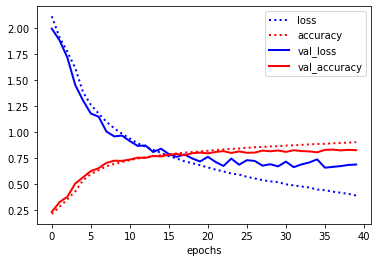

def build_model_1_3():
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))

    for i in range(n_hidden_layers):
        if i == (n_hidden_layers - 4):
            model.add(layers.Dropout(0.1))
        elif i == (n_hidden_layers - 3):
            model.add(layers.Dropout(0.2))
        elif i == (n_hidden_layers - 2):
            model.add(layers.Dropout(0.4))
        
        model.add(layers.Dense(n_nodes_hidden_layer[i], activation='relu'
                            #   ,kernel_regularizer=regularizers.l1_l2(l1=2e-4, l2=1e-3)))
                              ,activity_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-3)))
                            #   ,bias_regularizer=regularizers.l2(0.8)))  


    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer= SGD(learning_rate=1e-2, momentum=0.9, nesterov=True, decay=1e-2/epochs),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
  

In [6]:
print_answer(solution.answer_q_1_3)
run_evaluation("model_1_3", solution.build_model_1_3, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
%psource solution.build_model_1_3

#### Answer 2.1, ConvNet (7p)
- Build a sequential ConvNet, get at least 90% accuracy.
    - Conv2D layers, input shape (32,32,1)
    - Consider using blocks of Conv2D layers with maxpooling in between
    - Use zero-padding in Conv2D layers because the images are small
    - At least one dense hidden layer and dense output layer (sigmoid)
    - Consider adding batch normalization, dropout
    - Consider small dropout rates in beginning, larger dropout rates later in network
    - Consider other optimizers and tuning learning rate, momentum,...
- Explain what you did and why (800 chars). Is it working well?
    - Should be quite elaborate and sensible

Idea was to get high training accuracy (with possible overfit) and then regularize after using BatchNormalization and Dropout. To build deeper network it was better to have more layers than more filters. Thought behind subsequent conv2d layers (with the same filter size)  is that the kernel size starts big and then becomes smaller to focus on details. After every conv2d layer there is some processing by either batchnormalization or maxpooling; this is to regularize and get less overfit. Small dense part following to convert output to corresponding label. Different optimizers tried, but those were less stable and reaching less accuracy.  (length: 645)



Max val score: 94.78%


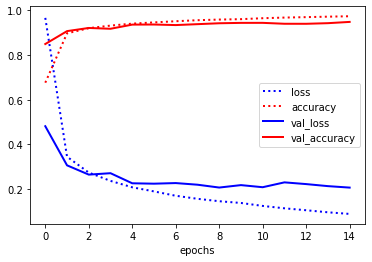

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        416       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        25120     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        25632     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 32)       

def build_model_2_1():   
    model = models.Sequential()

    model.add(Conv2D(16, kernel_size=(5, 5), activation='relu', padding='same',
                     input_shape=(32, 32, 1)))
    model.add(BatchNormalization())

    model.add(Conv2D(32, (7, 7), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())

    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same

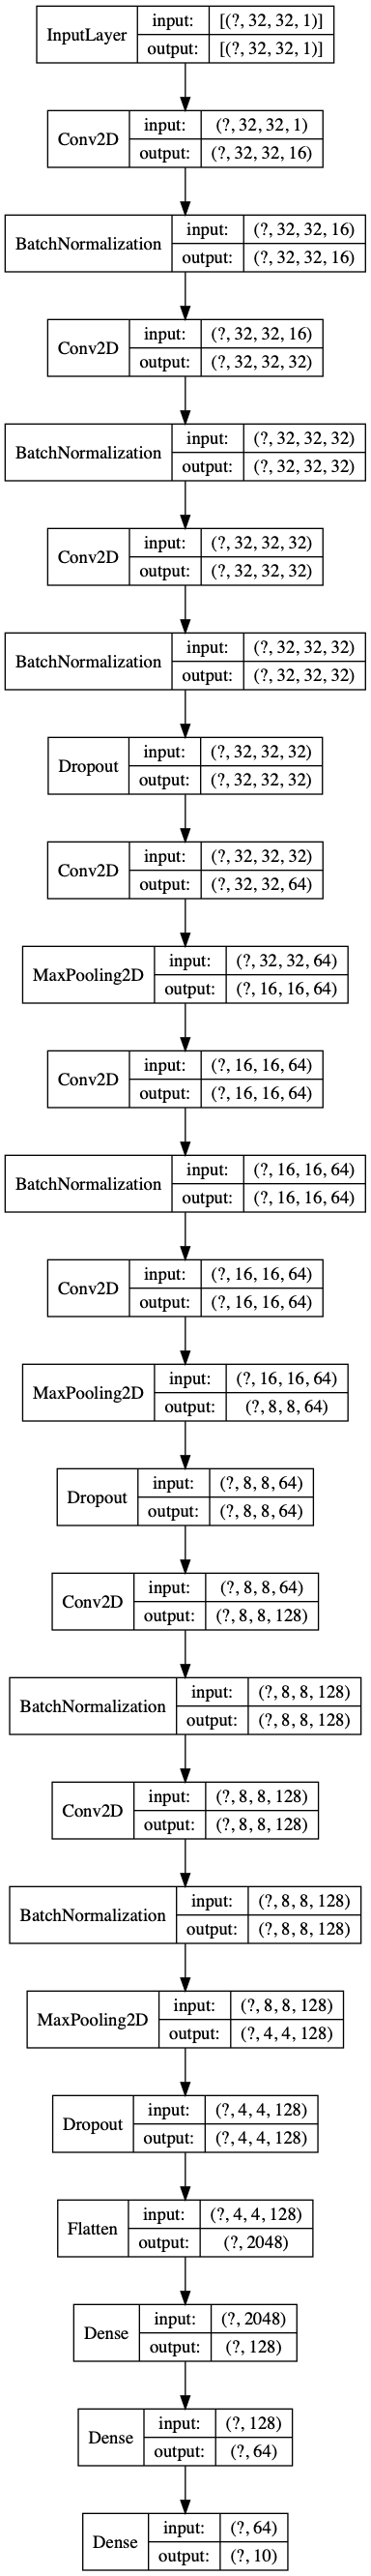

In [7]:
print_answer(solution.answer_q_2_1)
run_evaluation("model_2_1", solution.build_model_2_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_2_1
if os.path.exists(os.path.join(solution.target_dir,'model_2_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_2_1.png'), width=200))

#### Answer 2.2, Data Augmentation (3p)
- Augment the preprocessed training data.
    - Use small variations (small shifts up-down, left-right) of flips becasue the images are small
    - Large shifts and rotations distort the image too much
- Explain what you did and why. Discuss the performance of the model.

Get 0.7% improvement and no more overfitting. Best results with small (widht and height) shift ranges as the images are quite low resolution and rotation or sheer will destroy too much information. Overall best result is with shifting images only to the right to force the model to focus on the leftmost digit. This focus on the leftmost digit was found after Q3.1. Iteratino was happening between 2.2 and 3.1 to improve model.  (length: 429)



Max val score: 95.21%


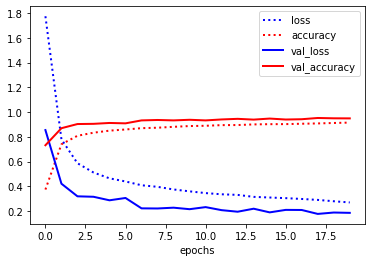


train_datagen = ImageDataGenerator(
    width_shift_range=[0, 16], # amount of pixels shift to right; 32 pixels present. Most left digit is actual label, so shift to right.
    # height_shift_range=0.1,
    # horizontal_flip=True,
    # preprocessing_function=preprocessing
    # rotation_range= 15,
    # zoom_range=0.2
    )


In [8]:
print_answer(solution.answer_q_2_2)
run_evaluation("model_2_2", solution.build_model_2_1, solution.augmented_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
print(solution.dg_code)

#### Answer 3.1, Misclassifications (2p)
- Report the test score (on the held-out test data)
    - Should be similar to score of previous model
- Plot confusion matrix, discuss which classes are often confused.
    - class 1 and 2 are most often confused
- Visualize the misclassifications in more depth by focusing on a single class
- Analyse which kinds of mistakes are made for that class.
    - Should contain some insight (e.g. misclassifications when the numbers are curly or noisy)

Often a 7 is predicted to be a 1 and a 5 is often seen as a 3, which is to be expected from their shape. 1 is more predicted in general as most samples are from this label, which also gives the most misclassifications. We therefore focus on 1 in misclassification.  We see pictures with multiple numbers (e.g. 156; model predicts a 5, while label is 1). In some other cases there is a lot of noise (e.g. insanely blurry), which makes it even unreadable for me. Lastly there are also multiple cases which seem to be incorrectly labeled; e.g. 2, 5 or 6 shown (and predicted), but 1 as label.  The data is imperfect and requires cleaning, such as correct labeling.  (length: 663)

Test score: 0.95%


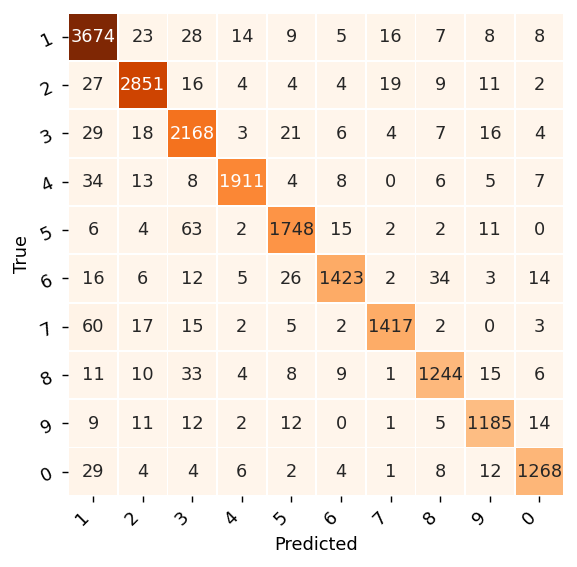

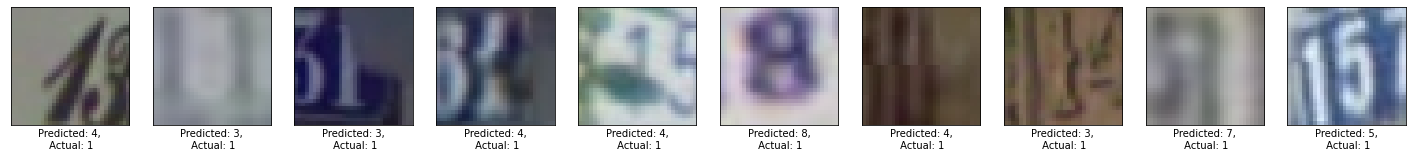

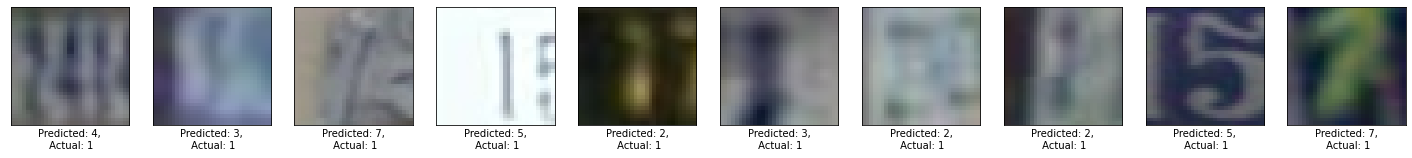

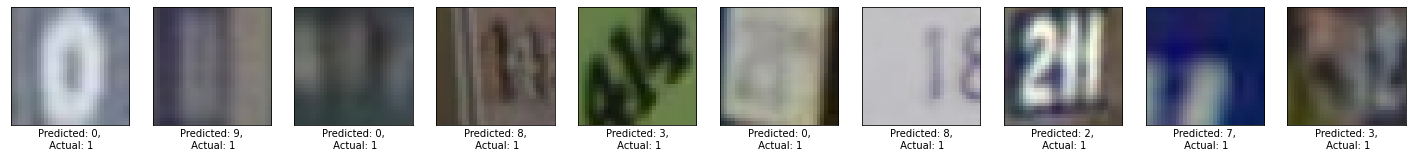

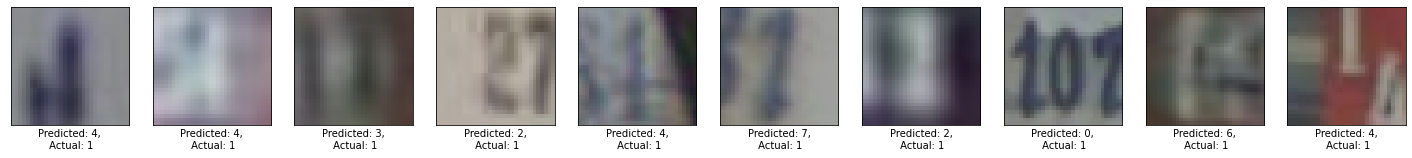

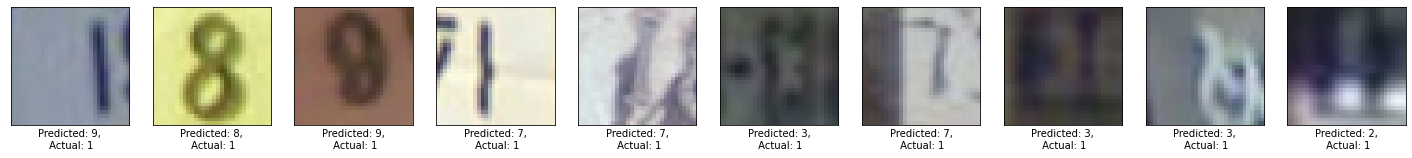

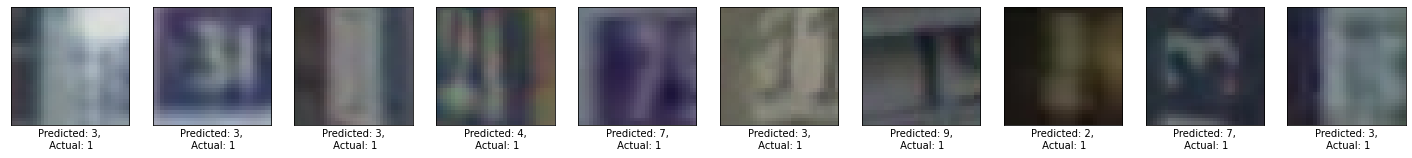

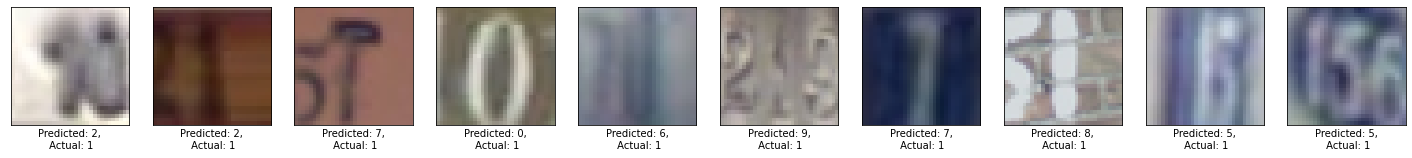

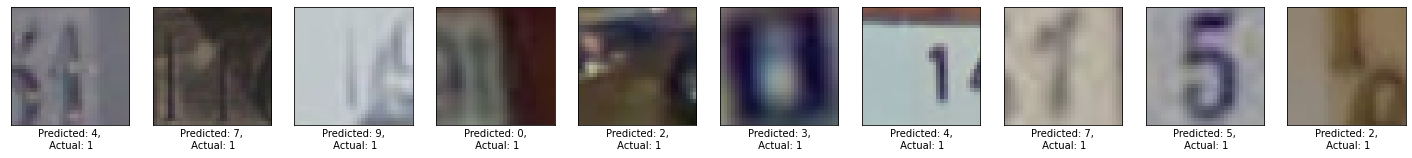

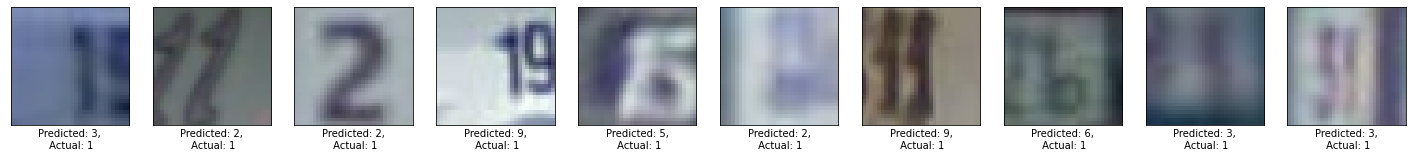

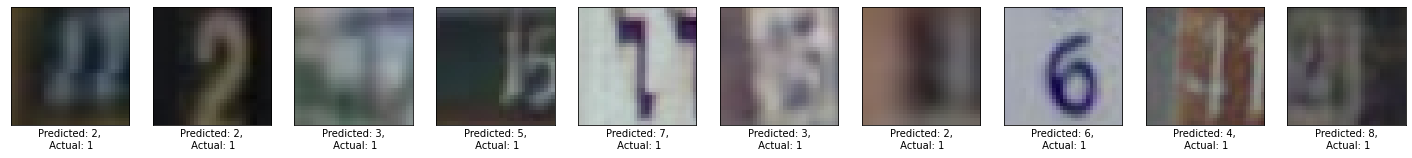

In [9]:
print_answer(solution.answer_q_3_1)
if hasattr(solution, 'test_accuracy_3_1'):
    try:
        print("Test score: {:.2f}%".format(solution.test_accuracy_3_1))
    except TypeError:
        print("Test score:",solution.test_accuracy_3_1)
else:
    print("Test score NOT FOUND: test_accuracy_3_1 missing")
try:
    solution.plot_confusion_matrix()
except:
    print("ERROR, could not build confusion matrix. Please check original report")
try:
    solution.plot_misclassifications()
except:
    print("ERROR, could not build misclassification plot. Please check original report")

#### Answer 3.2, Activations (4p)
- Retrieve and visualize the activations for one example
- For every filter for different convolutional layers (at different depths in the network).
- Give an explanation. Is your model indeed learning something useful?
    - Should detect edges etc in first layers, higher-order object (e.g. interesting regions) in deeper layers.

From the initial layers we can clearly see the the focus on the digit and the focus is on curvature of the outside of the 8-shape. Even in the 6th layer the 8-shape can still sort-of be seen. The model indeed learned something as it is focusing on edges of shape and not on the background.  The convolutional net mainly focuses on the center of the image (and not 5 in the top-right corner).   (length: 394)



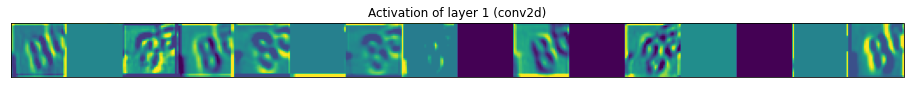

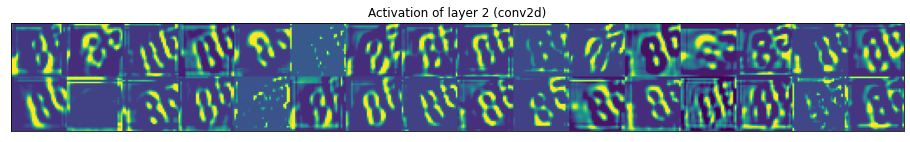

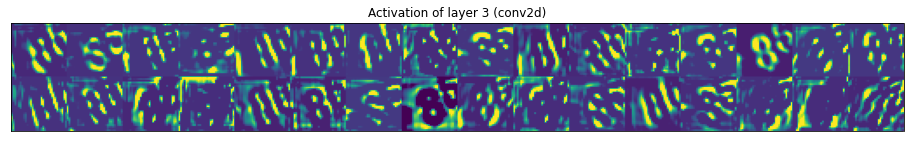

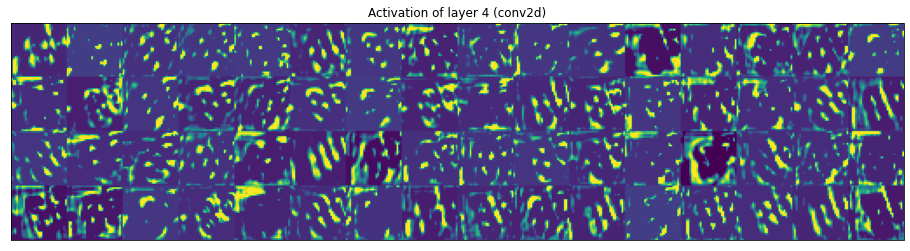

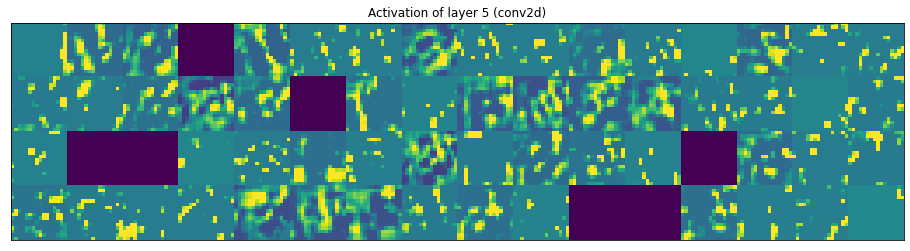

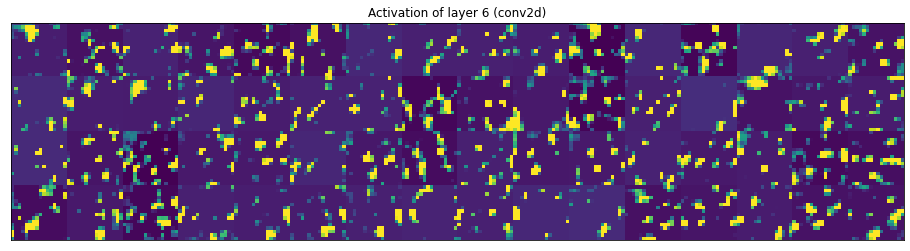

In [10]:
print_answer(solution.answer_q_3_2)
try:
    solution.plot_activations()
except:
    print("ERROR, could not build activation plot. Please check original report")

#### Answer 3.3, Class activation map (4p)
- Show a class activation map for your last convolutional layer
- Superimpose the activation map over the image, or plot side by side
    - Should make sense, detect interesting regions to classify the number

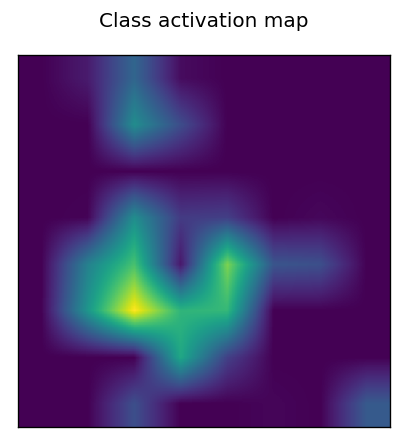

def plot_activation_map():
    img_tensor = preprocessing(X_test)[0]
    img_tensor = np.expand_dims(img_tensor, axis=0)
    conv_layer = [layer for layer in model_2_2.layers if 'conv2d' in layer.name][-1]
    heatmap_model = models.Model([model_2_2.inputs], [conv_layer.output, model_2_2.output])

    with tf.GradientTape() as tape:
        conv_output, predictions = heatmap_model(img_tensor)
        loss = predictions[:, np.argmax(predictions[0])]
        grads = tape.gradient(loss, conv_output)
        pooled_grads = K.mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)[0]

    # plot
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = cv2.resize(heatmap, (fig_size, fig_size))

    plt.rcParams['figure.dpi'] = 120
    plt.matshow(heatmap)
    plt.title('Class activation map')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
    return heatmap



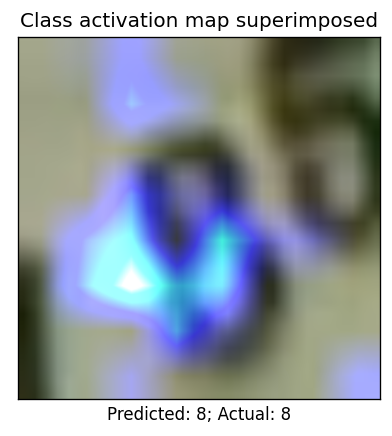

In [11]:
try:
    solution.plot_3_3()
except:
    print("ERROR, could not build class activation plot. Please check original report")
if hasattr(solution, 'plot_activation_map'):
    %psource solution.plot_activation_map
else:
    %psource solution.plot_3_3

#### Answer 4.1, Fast feature extraction (5p)
- Import the VGG16 model, pretrained on ImageNet
- Freeze convolutional base, adds a dense layer
- Consider unfreezing the last few convolutional layers and evaluate whether that works better
    - Check if they do. It is very likely to help.
- Discuss the observed performance
    - Should get around 80% accuracy

Model performs horribly compared to 2.2 and 2.1. Those have been trained from scratch, while VGG16 was made for imagenet and not digit classification.  Therefore fine-tuning is needed; improves accuracy significantly. It is overfitting, however the validation accuracy is way higher than before. Unfreezing less layers gave less validation accuracy, while still overfitting.  (length: 376)



Max val score: 86.62%


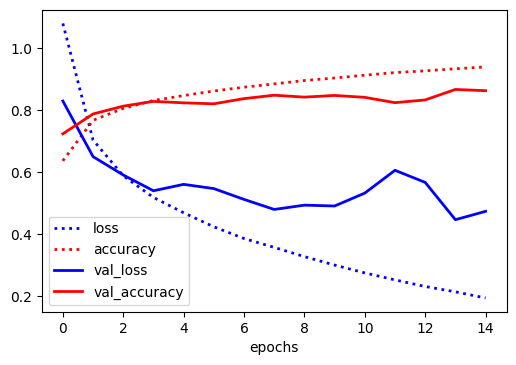

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

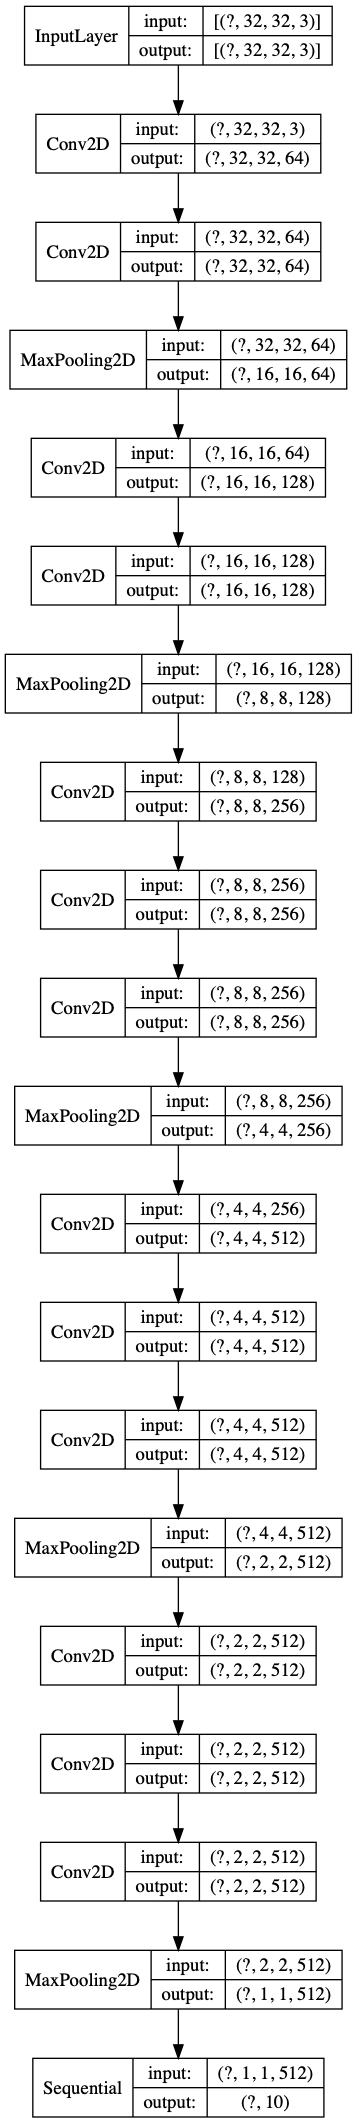

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

print_answer(solution.answer_q_4_1)
run_evaluation("model_4_1", solution.build_model_4_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_4_1
if os.path.exists(os.path.join(solution.target_dir,'model_4_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_4_1.png'), width=200))
#solution.build_model_4_1().layers[0].summary()

#### Answer 4.2, Embeddings (5p)
- Generate embeddings with the trained convolutional part of model_4_1 (without the dense layer)
- Embed the training and test data and store them to disk
- Build and evaluate a pipeline on the embedded data
    - Check if pipeline makes sense (e.g. use models that can handle many dimensions)
- Describe what you did and what you observed (max 800 chars).
    - Consider different models, preprocessing, tuning, etc.
    - Check performance (see original Submission.html) when in doubt. We did not run all the evaluations because it takes too long, and the output is ill-defined.

In [13]:
print_answer(solution.answer_q_4_2)
print(solution.generate_pipeline())
#print("Evaluation:",solution.evaluation_4_2(solution.X_train, solution.y_train, solution.X_test, solution.y_test))
%psource solution.store_embeddings
%psource solution.evaluation_4_2

Feature extraction as embedding. Non-DL techniques on itself were very slow (SVC, RF). Therefore different multilabel classifier; OneVsOne is faster than OneVsRest as sample size is quite high. LogisticRegression is both fast and performs well; slight improved accuracy by using normalizer. Not best model as 4.1 already didn't have 87%+ val. accuracy, so 87.7% from these features is reasonably good.  (length: 403)

Pipeline(steps=[('normalize', Normalizer()),
                ('clf',
                 OneVsOneClassifier(estimator=LogisticRegression(n_jobs=-1,
                                                                 random_state=1,
                                                                 solver='saga'),
                                    n_jobs=-1))])
def store_embeddings(X_train=X_train, X_test=X_test):
    """ Stores all necessary embeddings to file
    """
    # get model
    model_4_1 = load_model_from_file(base_dir, "model_4_1")

    # build model of convolutional bas

In [14]:
end_verify = time.time()
print("Running time: {:.2f} seconds".format(end_verify - start_verify))
print("Last modified: {}".format(solution.last_edit))
print("scikit-learn version: {0}".format(solution.sklearn_version))

with open(solution.grade_file, "a") as myfile:
    myfile.write(','.join(grades)+"\n")

Running time: 19.00 seconds
Last modified: May 26, 2020
scikit-learn version: 0.23.1
